<a href="https://colab.research.google.com/github/ALaaAlawdi/My-Kaggle-Notebooks/blob/main/x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pydicom

In [ ]:
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from skimage import exposure
from glob import glob
from scipy.io import wavfile
import warnings
from sklearn.model_selection import GroupKFold
from PIL import Image
import pathlib


In [ ]:
from google.colab import drive
from PIL import Image
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/contest-images')

In [ ]:
def plot_distribation_width_height(widths , heights ):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Image Width')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Widths')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='green', alpha=0.7)
    plt.xlabel('Image Height')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Heights')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_bytes_distrubation(image_sizes):
    plt.hist(image_sizes, bins=20, color='red', alpha=0.7)
    plt.xlabel('Image Size (Bytes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Sizes (Bytes)')

In [ ]:

def extract_image_info(image_dir):
    # Initialize empty lists to store image information
    image_paths = []
    image_widths = []
    image_heights = []
    image_sizes = []

    # Iterate through all files in the image directory
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):  # Adjust extensions as needed
            # Build the full file path
            file_path = os.path.join(image_dir, filename)

            # Open the image and extract information
            with Image.open(file_path) as img:
                width, height = img.size
                size = os.path.getsize(file_path)

                # Append information to respective lists
                image_paths.append(file_path)
                image_widths.append(width)
                image_heights.append(height)
                image_sizes.append(size)

    # Create a DataFrame to store image information
    data = {
        'Image Path': image_paths,
        'Width': image_widths,
        'Height': image_heights,
        'Size (bytes)': image_sizes
    }

    df = pd.DataFrame(data)

    return df

In [ ]:
image_directory = '/content/drive/MyDrive/contest-images'
image_info_df = extract_image_info(image_directory)

# Save the DataFrame to a CSV file
image_info_df.to_csv('/content/sample_data/data_detals.csv', index=False)

# Display the DataFrame
print(image_info_df)

                                          Image Path  Width  Height  \
0      /content/drive/MyDrive/contest-images/172.png   1024    1024   
1      /content/drive/MyDrive/contest-images/274.png   1024    1024   
2      /content/drive/MyDrive/contest-images/195.png   1024    1024   
3       /content/drive/MyDrive/contest-images/44.png   1024    1024   
4      /content/drive/MyDrive/contest-images/221.png   1024    1024   
...                                              ...    ...     ...   
1395   /content/drive/MyDrive/contest-images/886.png   1024    1024   
1396  /content/drive/MyDrive/contest-images/1111.png   1024    1024   
1397  /content/drive/MyDrive/contest-images/1055.png   1024    1024   
1398   /content/drive/MyDrive/contest-images/867.png   1024    1024   
1399   /content/drive/MyDrive/contest-images/266.png   1024    1024   

      Size (bytes)  
0           414490  
1           393925  
2           398973  
3           338449  
4           407502  
...            ...  


In [ ]:
print("The mean width is :" , image_info_df['Width'].mean() )
print("The mean Height is :" , image_info_df['Height'].mean())
print("The mean of size image: " ,  image_info_df['Size (bytes)'].mean())

The mean width is : 1024.0
The mean Height is : 1024.0
The mean of size image:  397381.425


In [ ]:
# Current mean size of each image in bytes
mean_size_per_image = 397408.6559600285  # in bytes

# Total number of images
total_images = 1400

# Calculate the current total size of all images in megabytes
current_total_size_mb = (mean_size_per_image * total_images) / (1024 * 1024)  # Convert bytes to megabytes

# Desired total size in megabytes (less than 80 MiB)
desired_total_size_mb = 50  # 80 MiB in megabytes

# Calculate the reduction factor
reduction_factor = desired_total_size_mb / current_total_size_mb

# Calculate how much to reduce the size of each image in megabytes
reduction_per_image_mb = (mean_size_per_image / (1024 * 1024)) * (1 - reduction_factor)  # Convert bytes to megabytes

print("Current Total Size:", round(current_total_size_mb , 2) , "MB")
print("Desired Total Size:", round(desired_total_size_mb,2) , "MB")
print("Reduction Factor:", round(reduction_factor , 2 ))
print("Reduction per Image:", round(reduction_per_image_mb , 2 ), "MB")


Current Total Size: 530.6 MB
Desired Total Size: 50 MB
Reduction Factor: 0.09
Reduction per Image: 0.34 MB


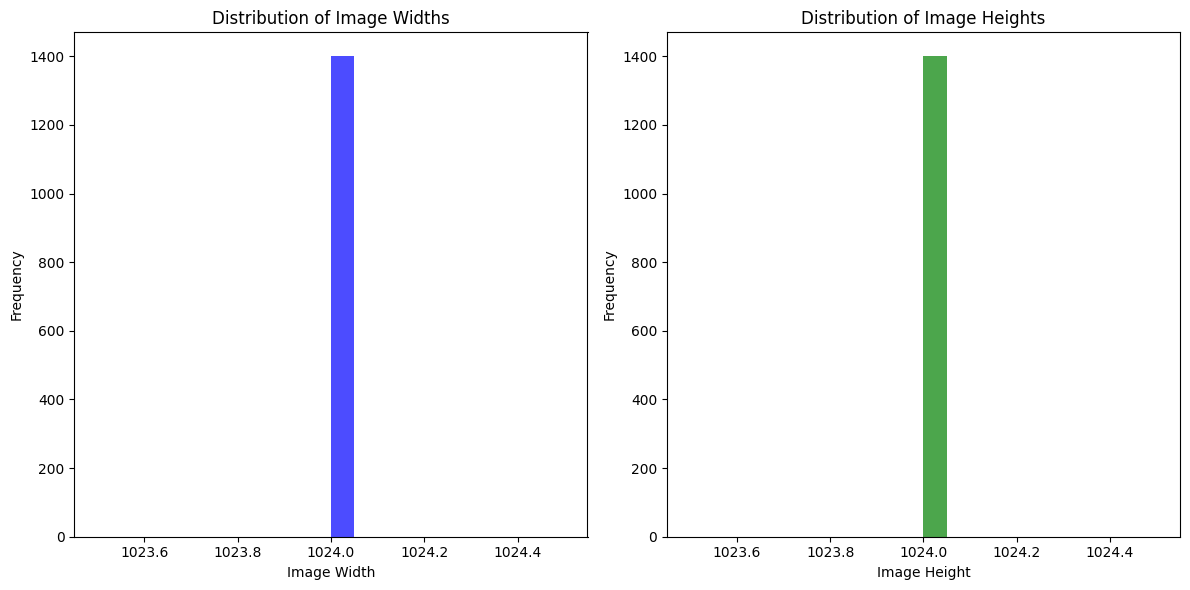

In [ ]:
plot_distribation_width_height(image_info_df['Width'] , image_info_df['Height'] , )

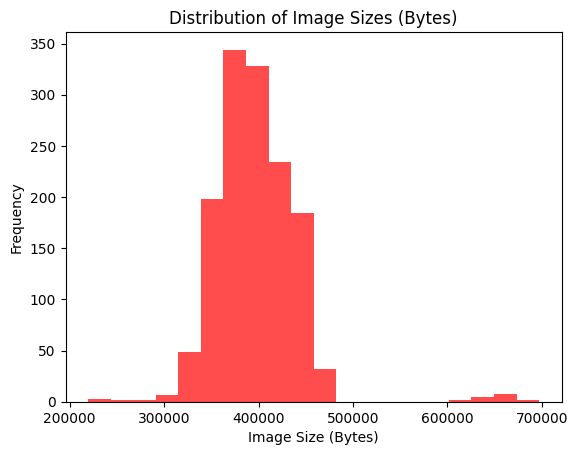

In [ ]:
plot_bytes_distrubation(image_info_df['Size (bytes)'])

In [ ]:
# !pip install pydicom numpy matplotlib opencv-python
!pip  install scikit-image

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def image_file_to_array(path):
    # Read the image using OpenCV
    image = cv2.imread(path)

    if image is None:
        raise ValueError(f"Failed to read image from {path}")

    # Convert the image to grayscale if it's a color image
    if len(image.shape) > 2 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize the pixel values to the range [0, 255]
    image = image - np.min(image)
    image = image / np.max(image)
    image = (image * 255).astype(np.uint8)

    return image

def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500, 500)):
    rows = len(imgs) // cols + 1
    fig = plt.figure(figsize=(cols * size, rows * size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()



# Enhancement trial

In [ ]:
# Example usage
# Replace 'image_info_df['Image Path'][:8].tolist()' with your list of image file paths
imgs = [image_file_to_array(path) for path in image_info_df['Image Path'][:8].tolist()]
plot_imgs(imgs)

In [ ]:
invert = 256 - np.array(imgs)
plot_imgs(invert)

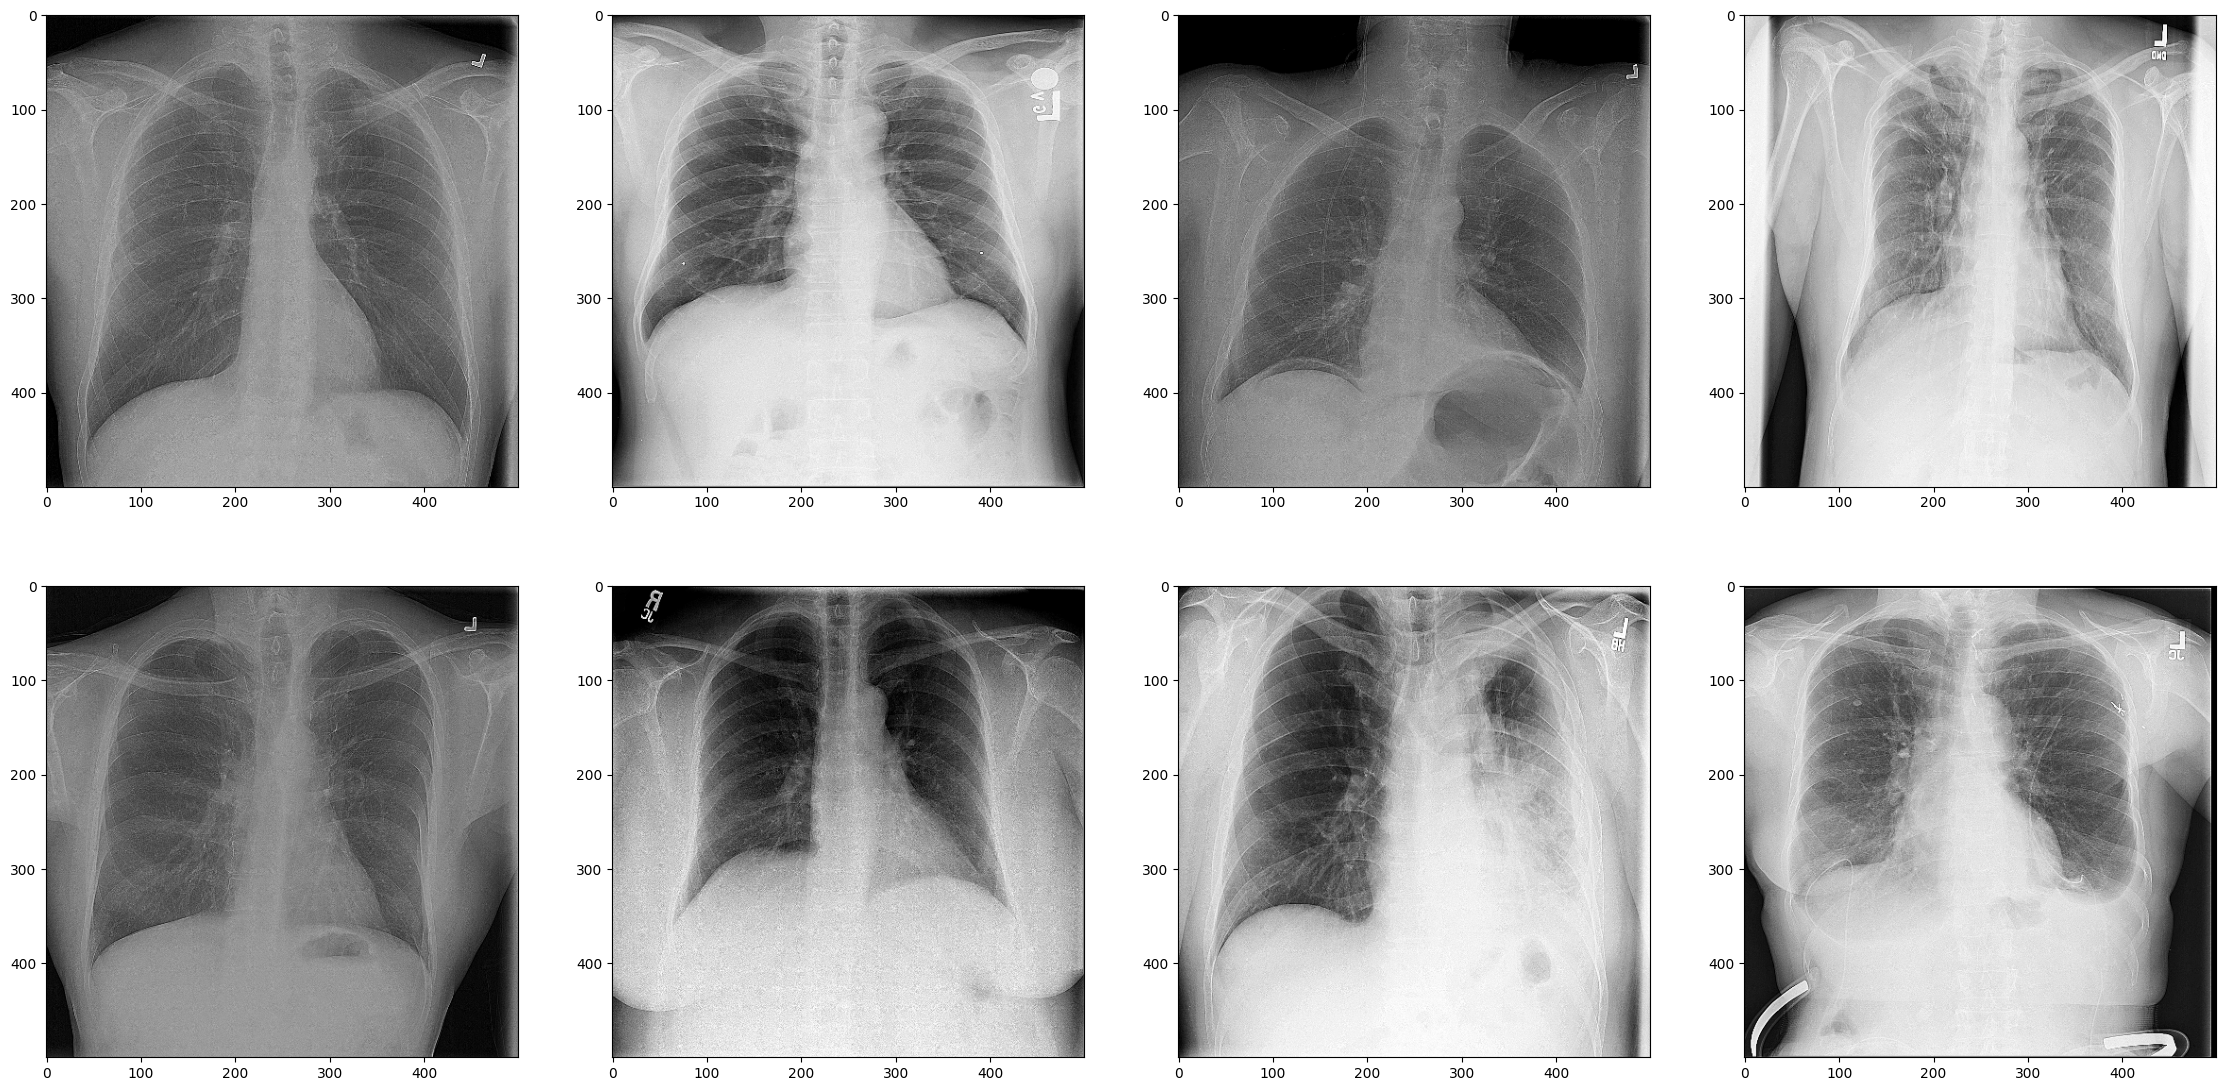

In [ ]:
hf1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

after_hf1 = [cv2.filter2D(img, -1, hf1) for img in imgs]
plot_imgs(after_hf1)

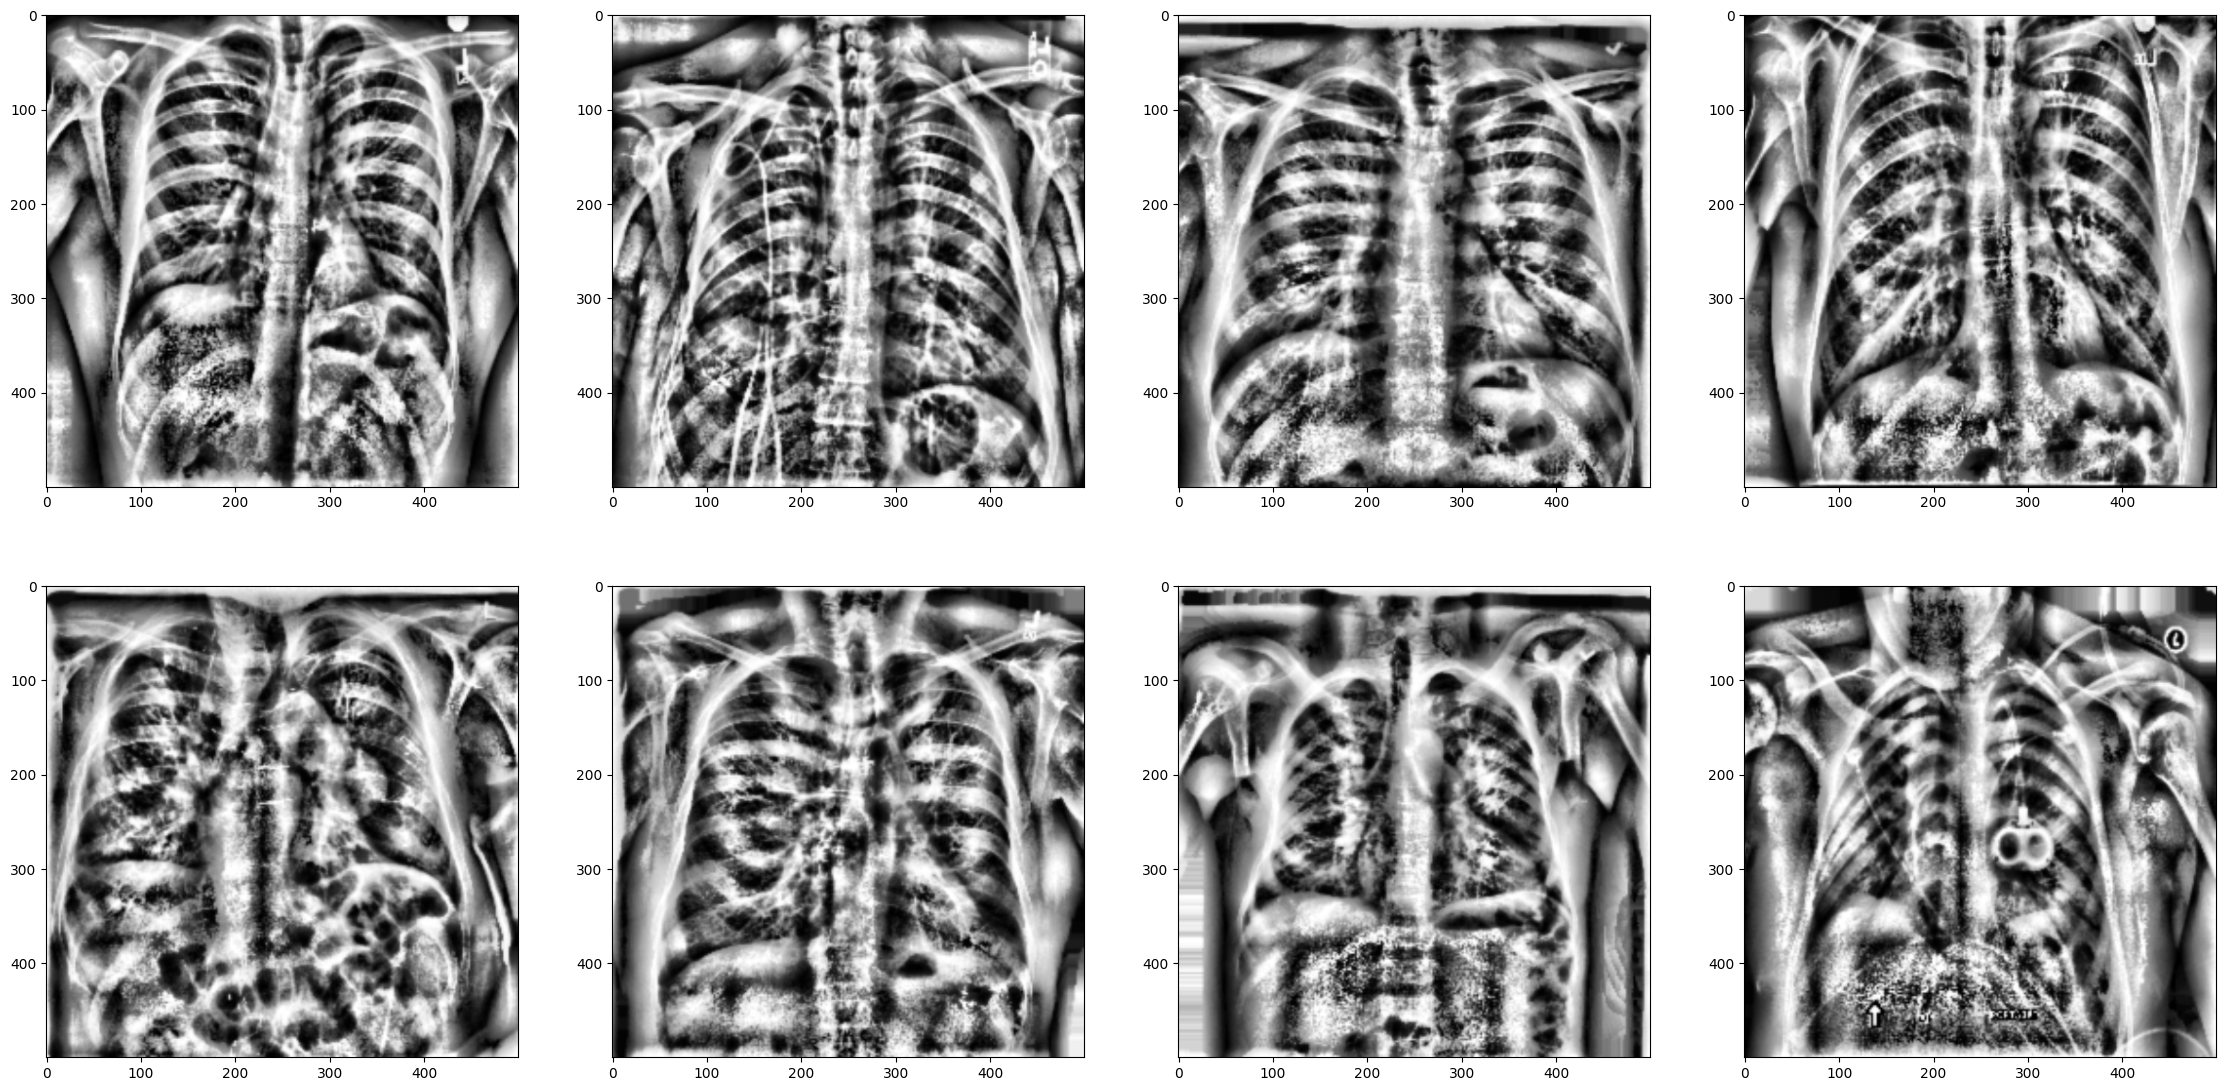

In [ ]:
hist_eq = [cv2.equalizeHist(img) for img in imgs]
plot_imgs(hist_eq)

In [ ]:
def clahe(image):
    clahe = cv2.createCLAHE(
        clipLimit = 2.,
        tileGridSize = (10, 10)
    )

    image = clahe.apply(image)
    #image = tf.expand_dims(image, axis = 2)

    return image

**CLAHE (Contrast Limited Adaptive Histogram Equalization)**

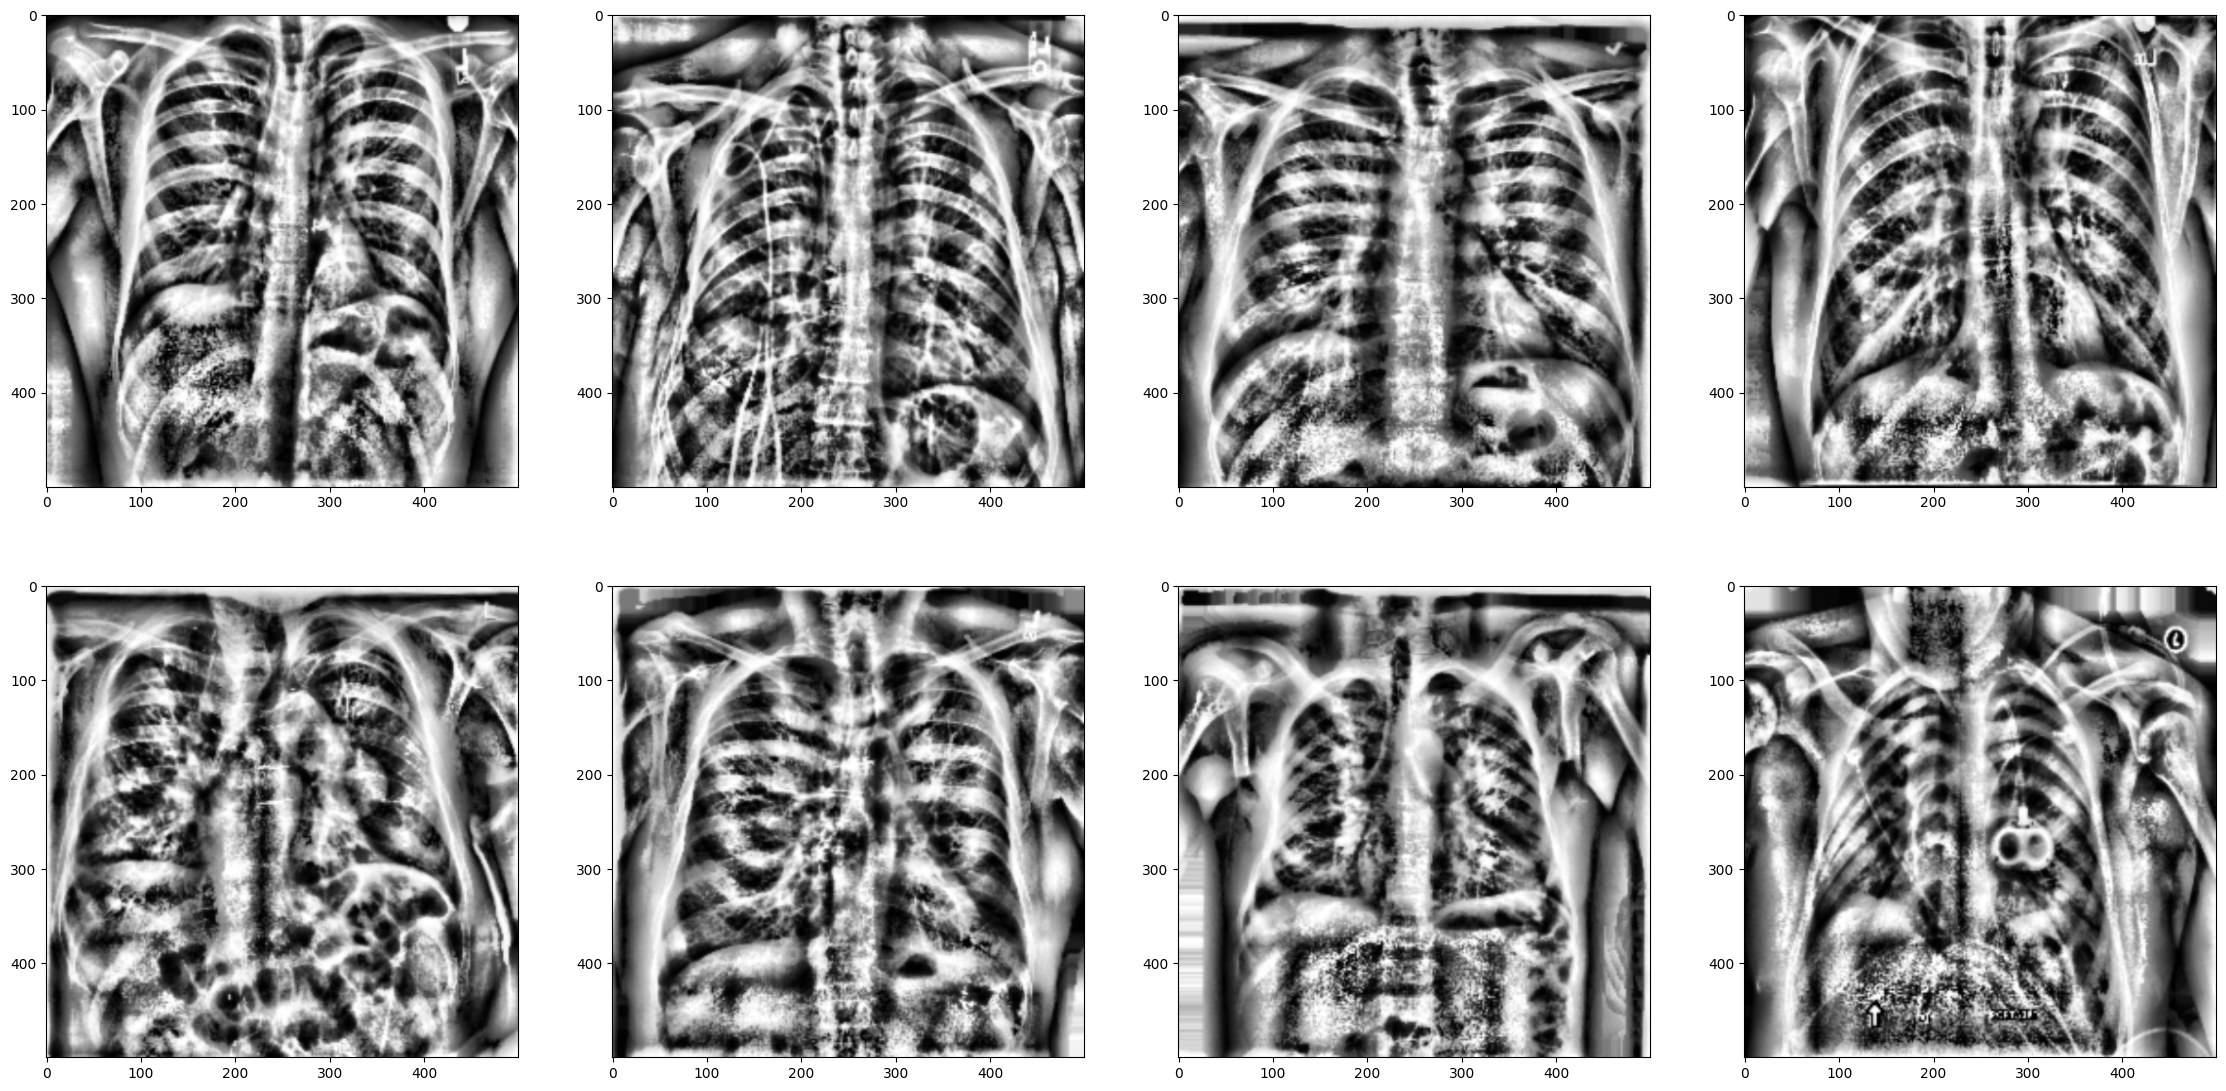

In [ ]:
clahe_ = [clahe(img) for img in imgs]
plot_imgs(clahe_)

# It looks the best

# Save Enhancemented Images with .png forma

In [ ]:
save_path = '/content/sample_data/Enhancements_data'
images = image_info_df['Image Path']
new_width = 256
new_height = 256

# Initialize variables to keep track of the total size
total_size = 0

for image in images:
    img_path = os.path.join(image)
    ori_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image
    resized_img = cv2.resize(ori_img, (new_width, new_height))  # Specify the new width and height

    # Calculate the size of the resized image
    img_size = os.path.getsize(img_path)
    total_size += img_size

    # Apply CLAHE
    dst_img = clahe(resized_img)

    # Save the processed image
    cv2.imwrite(os.path.join(save_path, image), dst_img)

# Print the total size of all resized images
print(f"Total size of resized images: {(total_size / 1024) } bytes")

Processed and saved: /content/sample_data/Enhancements_data/172.png
Processed and saved: /content/sample_data/Enhancements_data/274.png
Processed and saved: /content/sample_data/Enhancements_data/195.png
Processed and saved: /content/sample_data/Enhancements_data/44.png
Processed and saved: /content/sample_data/Enhancements_data/221.png
Processed and saved: /content/sample_data/Enhancements_data/95.png
Processed and saved: /content/sample_data/Enhancements_data/341.png
Processed and saved: /content/sample_data/Enhancements_data/113.png
Processed and saved: /content/sample_data/Enhancements_data/207.png
Processed and saved: /content/sample_data/Enhancements_data/1242.png
Processed and saved: /content/sample_data/Enhancements_data/320.png
Processed and saved: /content/sample_data/Enhancements_data/303.png
Processed and saved: /content/sample_data/Enhancements_data/204.png
Processed and saved: /content/sample_data/Enhancements_data/160.png
Processed and saved: /content/sample_data/Enhance

In [ ]:

print(len(os.listdir(save_path)))
sample = cv2.imread(os.path.join(save_path, images[0]))
plt.imshow(sample)

In [ ]:

# path = '/kaggle/working/vinbigdata/images/train'
# save_path = '/kaggle/working/vinbigdata_processed/images/train'
# images = os.listdir(path)

# # Initialize variables to keep track of the total size
# total_size = 0

# def clahe(image):
#     # Your CLAHE processing code here
#     # Assuming you have the function clahe() defined elsewhere in your code
#     return image

# for image in images:
#     img_path = os.path.join(path, image)
#     ori_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#     # Resize the image
#     resized_img = cv2.resize(ori_img, (new_width, new_height))  # Specify the new width and height

#     # Calculate the size of the resized image
#     img_size = os.path.getsize(img_path)
#     total_size += img_size

#     # Apply CLAHE
#     dst_img = clahe(resized_img)

#     # Save the processed image
#     cv2.imwrite(os.path.join(save_path, image), dst_img)

# # Print the total size of all resized images
# print(f"Total size of resized images: {total_size} bytes")

In [61]:
!git init

Reinitialized existing Git repository in /content/drive/MyDrive/contest-images/.git/


In [62]:
!git add README.md

In [64]:

!git config --global user.email "AlaaAlawdi01.com"
!git config --global user.name "ALaaAlawdi"


In [65]:
!git commit -m "first commit"

[main (root-commit) 42f04d5] first commit
 1401 files changed, 1 insertion(+)
 create mode 100644 0.png
 create mode 100644 1.png
 create mode 100644 10.png
 create mode 100644 100.png
 create mode 100644 1000.png
 create mode 100644 1001.png
 create mode 100644 1002.png
 create mode 100644 1003.png
 create mode 100644 1004.png
 create mode 100644 1005.png
 create mode 100644 1006.png
 create mode 100644 1007.png
 create mode 100644 1008.png
 create mode 100644 1009.png
 create mode 100644 101.png
 create mode 100644 1010.png
 create mode 100644 1011.png
 create mode 100644 1012.png
 create mode 100644 1013.png
 create mode 100644 1014.png
 create mode 100644 1015.png
 create mode 100644 1016.png
 create mode 100644 1017.png
 create mode 100644 1018.png
 create mode 100644 1019.png
 create mode 100644 102.png
 create mode 100644 1020.png
 create mode 100644 1021.png
 create mode 100644 1022.png
 create mode 100644 1023.png
 create mode 100644 1024.png
 create mode 100644 1025.png
 crea

In [67]:
# !echo "# x-ray-images" >> README.md
# !git init
# !git add README.md
# !git commit -m "first commit"
# !git branch -M main
!git remote add origin https://github.com/ALaaAlawdi/x-ray-images.git


error: remote origin already exists.


In [68]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [56]:
!git remote add origin https://github.com/ALaaAlawdi/x-ray-images.git



error: remote origin already exists.
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/ALaaAlawdi/x-ray-images.git'


In [69]:
!git branch -M main

In [70]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [59]:
!git add .

In [60]:
!git pull

There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> main

